<a href="https://colab.research.google.com/github/kavya6301/IBDM-movie-review-prediction/blob/code/IBDM_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
imdb_data=pd.read_csv('/content/drive/MyDrive/Projects/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [4]:
#sentiment count
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [5]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [10]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [12]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [13]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [14]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'shouldn', 'my', "you'd", 'while', "isn't", 'you', 'shan', 'hers', 'down', 'm', 'having', 'there', "wasn't", 'wouldn', 'own', 'don', 's', 'too', "aren't", 'those', 'some', 'how', 'about', 'will', 'most', 'of', 'i', 'with', 'because', 'during', 'and', 'where', 'more', 'whom', 'have', 'our', "weren't", 'or', "wouldn't", 'hadn', 'himself', 'until', 'themselves', 'he', 'isn', 'so', 'were', 'any', 'below', "hasn't", 'that', 'couldn', "mustn't", "it's", 'here', 'aren', 'be', 'won', 'not', 'by', 'off', 'we', 'should', "you're", 'after', 'your', 'herself', 'haven', 'this', 'at', 'a', 'up', 'ourselves', 'myself', 'between', 'me', "doesn't", 'y', 'his', 'these', 'd', 'which', 'its', 'such', "don't", 'over', 'once', "you'll", 'only', 'now', 'been', 'why', 'before', 'when', 'out', 'wasn', 'for', 'both', 'are', 'ours', 'few', 'further', 'above', "she's", 'their', 'each', 'to', 'under', 'him', 'hasn', "shan't", 'nor', "won't", 'if', 'again', 'all', 'very', 'doesn', "didn't", 'other', 'did', 've', '

In [15]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]
#convert dataframe to string

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [16]:
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]
##convert dataframe to string

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

In [17]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


In [23]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


In [18]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [20]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [24]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [25]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [26]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


In [27]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [28]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


In [29]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [30]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [32]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [33]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


In [34]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [35]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


<function matplotlib.pyplot.show>

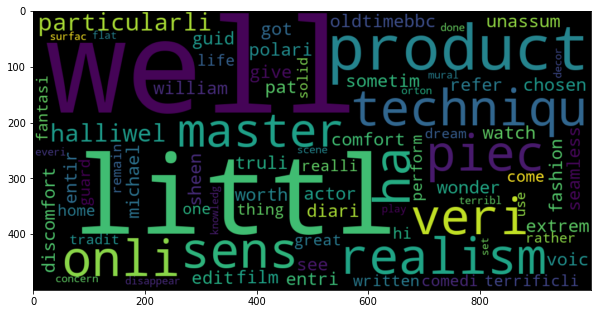

In [36]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show>

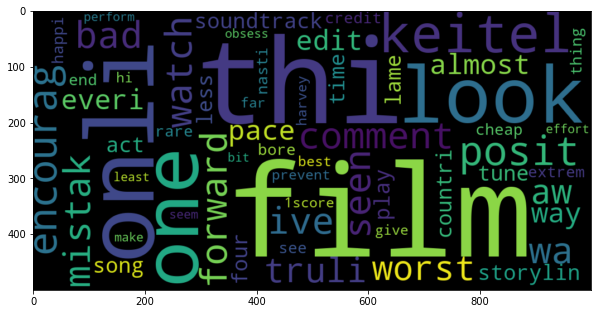

In [37]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show